In [2]:
# 1st Code Cell
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os        

%matplotlib inline

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1280 # meters per pixel in x dimension

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


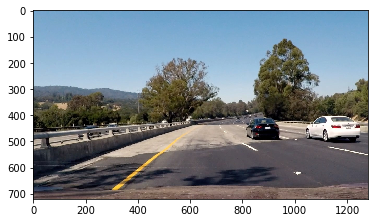

In [3]:
# 2nd Code Cell
#reading in an image
os.listdir("test_images/")
test_image = mpimg.imread('test_images/test4.jpg')

path = os.path.realpath('test_images/straight_lines2.jpg')
filename_w_ext = os.path.basename(path)
filename, file_extension = os.path.splitext(filename_w_ext)

#printing out some stats and plotting
print('This image is:', type(test_image), 'with dimensions:', test_image.shape)
plt.imshow(test_image)  

filename_new = 'output_images'+'/'+ 'original_raw_picture'+file_extension
mpimg.imsave(filename_new, test_image)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


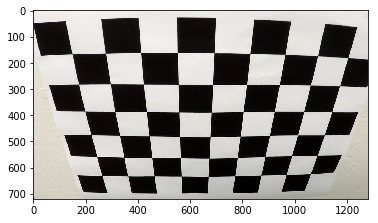

In [4]:
# 3rd Code Cell
# Calibrate the camera
calibration_image = mpimg.imread('camera_cal/calibration2.jpg')

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

#printing out some stats and plotting
print('This image is:', type(calibration_image), 'with dimensions:', calibration_image.shape)
plt.imshow(calibration_image) 


filename_new = 'output_images'+'/'+ 'original chessboard'+file_extension
mpimg.imsave(filename_new, calibration_image)

In [5]:
# 4th Code Cell
def camera_calibation(image):
    '''
    Calculate mtx and dist for this camera
    '''
    # Array to store objects points and image points fom all the images
    objpoints = []
    imgpoints = []

    # Prepare object points, like (0, 0, 0), (1, 0, 0), ..., (8, 5, 0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        mtx = np.zeros((3,3),dtype=float)
        dist = np.zeros((1,5),dtype=float)
    return mtx, dist, ret



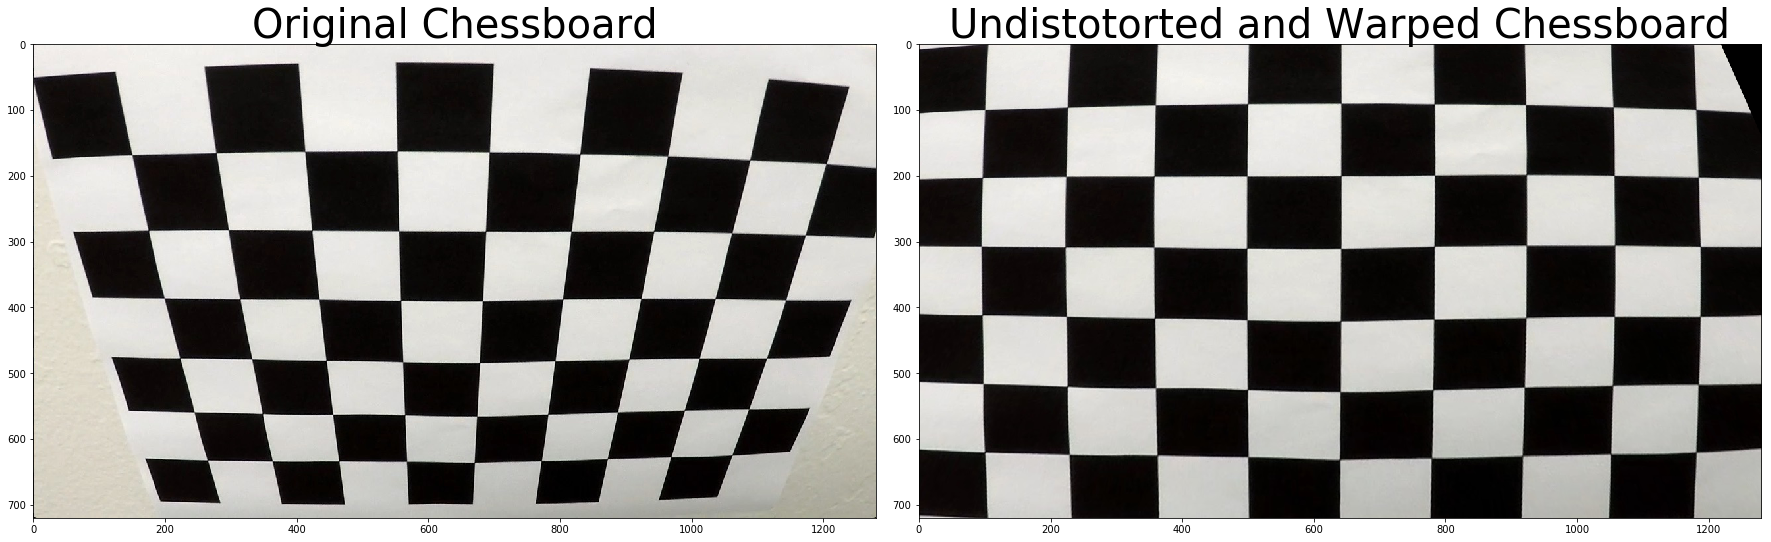

In [6]:
# 5th Code Cell
def undistort_chessboard(image, mtx, dist, ret):
    '''
    Undistort an chessboard picture to check if the undistort functino is working or not
    '''
    if ret == True:
        # Undistort using mtx and dist
        undist = cv2.undistort(image, mtx, dist, None, mtx)
    else:
        undist = np.copy(image)
        
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
            offset = 100 # offset for dst points
            # Grab the image shape
            img_size = (gray.shape[1], gray.shape[0])

            # For source points I'm grabbing the outer four detected corners
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            # For destination points, I'm arbitrarily choosing some points to be
            # a nice fit for displaying our warped result 
            # again, not exact, but close enough for our purposes
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                         [img_size[0]-offset, img_size[1]-offset], 
                                         [offset, img_size[1]-offset]])
            # Given src and dst points, calculate the perspective transform matrix
            M = cv2.getPerspectiveTransform(src, dst)
            Minv = cv2.getPerspectiveTransform(dst, src)
            # Warp the image using OpenCV warpPerspective()
            warped = cv2.warpPerspective(undist, M, img_size)
    else:
        warped = np.copy(undist)

    return warped

mtx_chessboard, distchessboard, ret_chessboard = camera_calibation(calibration_image)
warped_chessboard= undistort_chessboard(calibration_image, mtx_chessboard, distchessboard, ret_chessboard)

filename_new = 'output_images'+'/'+ 'undistorted_and_warped_chessboard'+file_extension
mpimg.imsave(filename_new, warped_chessboard)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(calibration_image)
ax1.set_title('Original Chessboard', fontsize=40)

ax2.imshow(warped_chessboard)
ax2.set_title('Undistotorted and Warped Chessboard', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
# 6th Code Cell
def camera_calibation_all():
    '''
    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
    '''
    mtx_sum = np.zeros((3,3),dtype=float)
    dist_sum = np.zeros((1,5),dtype=float)
    mtx_ave = np.zeros((3,3),dtype=float)
    dist_ave = np.zeros((1,5),dtype=float)
    number_of_cal_image = 0

    for cal_image in os.listdir("camera_cal/"):
        path = os.path.realpath(cal_image)
        filename_w_ext = os.path.basename(path)
        filename, file_extension = os.path.splitext(filename_w_ext)

        # Read in the image
        image = mpimg.imread("camera_cal/"+filename_w_ext)

        mtx, dist, ret = camera_calibation(image)

        if ret != False:
            number_of_cal_image += 1
            # Add to mtx_sum
            for i in range(len(mtx)):
                for j in range(len(mtx[0])):
                    mtx_sum[i][j] += mtx[i][j]
    
            # Add to dist_sum
            for i in range(len(dist[0])):
                dist_sum[0][i] += dist[0][i]

    for i in range(len(mtx_sum)):
        for j in range(len(mtx_sum[0])):
            mtx_ave[i][j] = mtx_sum[i][j]/number_of_cal_image

    for i in range(len(dist_sum[0])):
        dist_ave[0][j] = dist_sum[0][j]/number_of_cal_image  
    return mtx_ave, dist_ave

mtx_chessboard_all, dist_chessboard_all = camera_calibation_all()

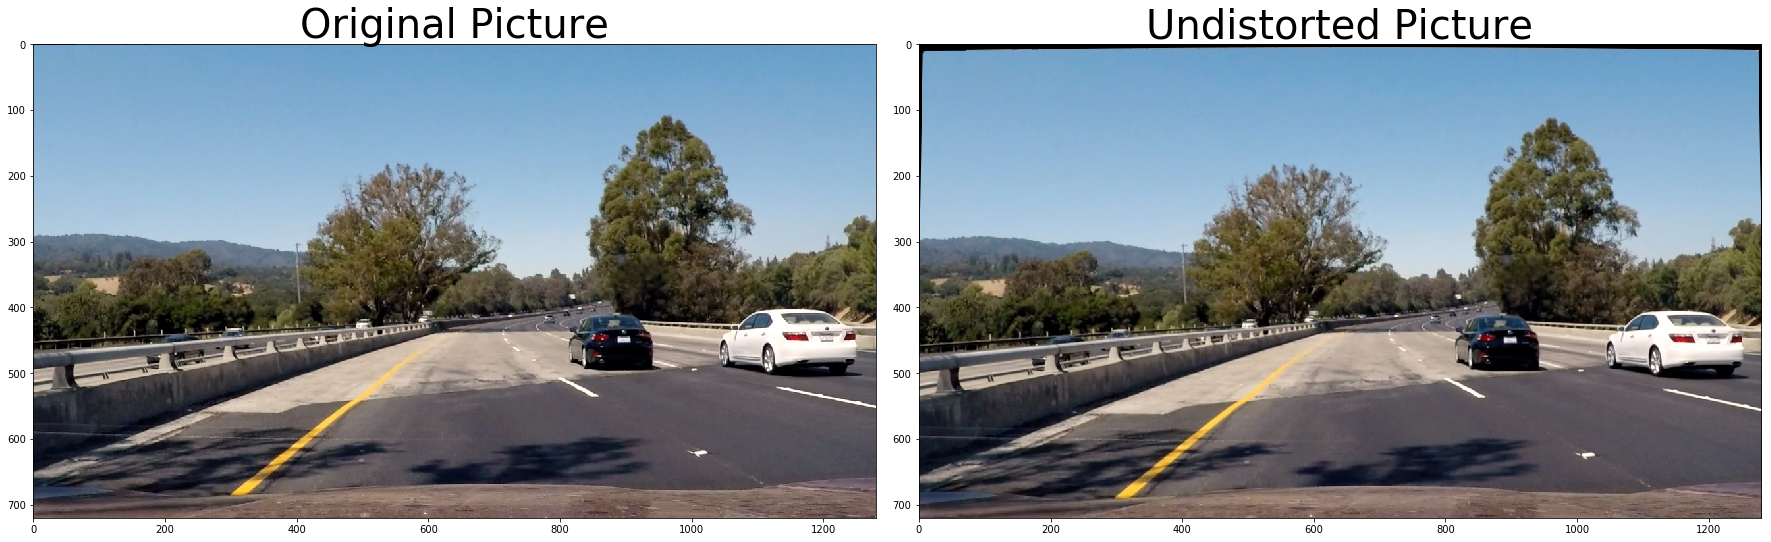

In [8]:
# 7th Code Cell
def undistort_image(image, mtx, dist):
    '''
    Apply a distortion correction to raw images.
    '''
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

undistort_test_image = undistort_image(test_image, mtx_chessboard_all, dist_chessboard_all)

filename_new = 'output_images'+'/'+ 'undistorted_picture'+file_extension
mpimg.imsave(filename_new, undistort_test_image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original Picture', fontsize=40)

ax2.imshow(undistort_test_image)
ax2.set_title('Undistorted Picture', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

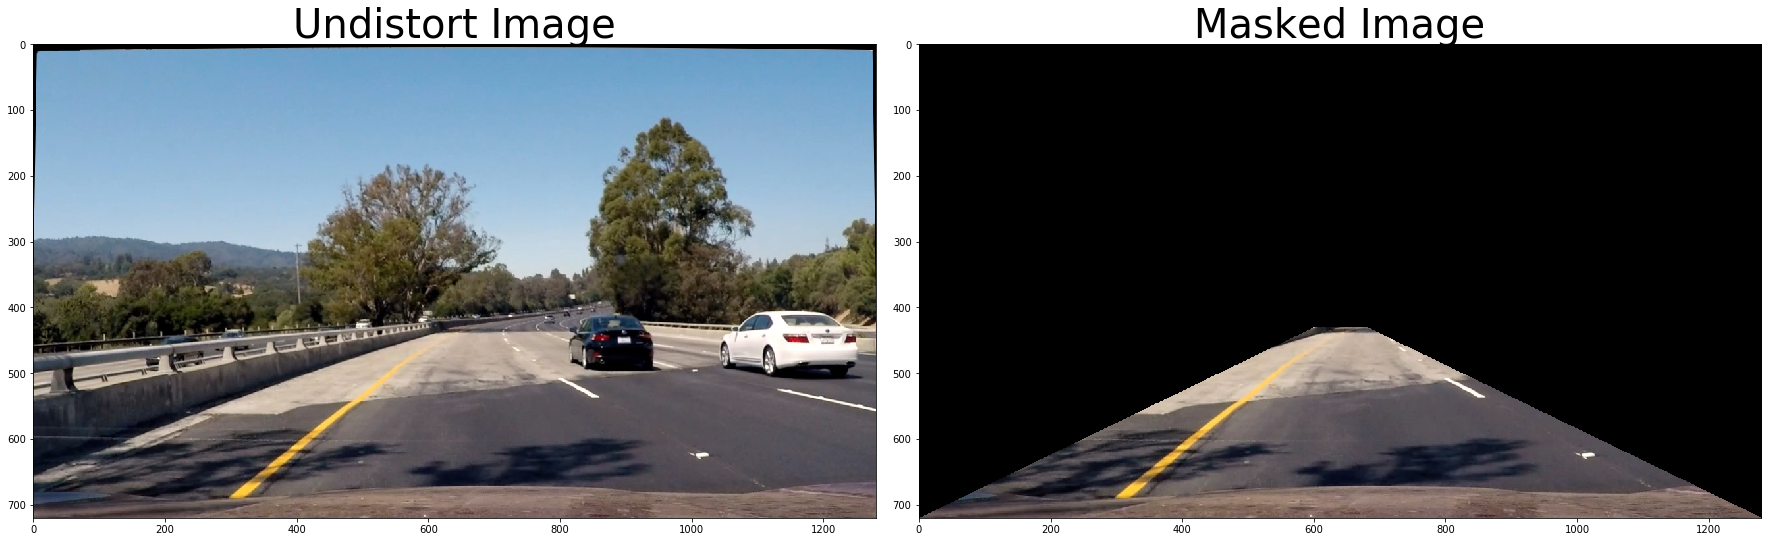

In [9]:
# 8th Code Cell
def region_of_interest(img, vertices):
    '''
    Mask picture to only area of interest
    '''
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def define_vertices(img):
    '''
    Define the area of interest
    '''
    imshape = img.shape
    top_left = (imshape[1]/2 - 40, imshape[0]/2 + 70)
    top_right = (imshape[1]/2 + 40, imshape[0]/2 + 70)
    vertices = np.array([[(0,imshape[0]),top_left, top_right, (imshape[1],imshape[0])]], dtype=np.int32)
    return vertices
    
vertices_test_image = define_vertices(undistort_test_image)
masked_test_image = region_of_interest(undistort_test_image, vertices_test_image)

filename_new = 'output_images'+'/'+ 'masked_image'+file_extension
mpimg.imsave(filename_new, masked_test_image)
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistort_test_image)
ax1.set_title('Undistort Image', fontsize=40)

ax2.imshow(masked_test_image)
ax2.set_title('Masked Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

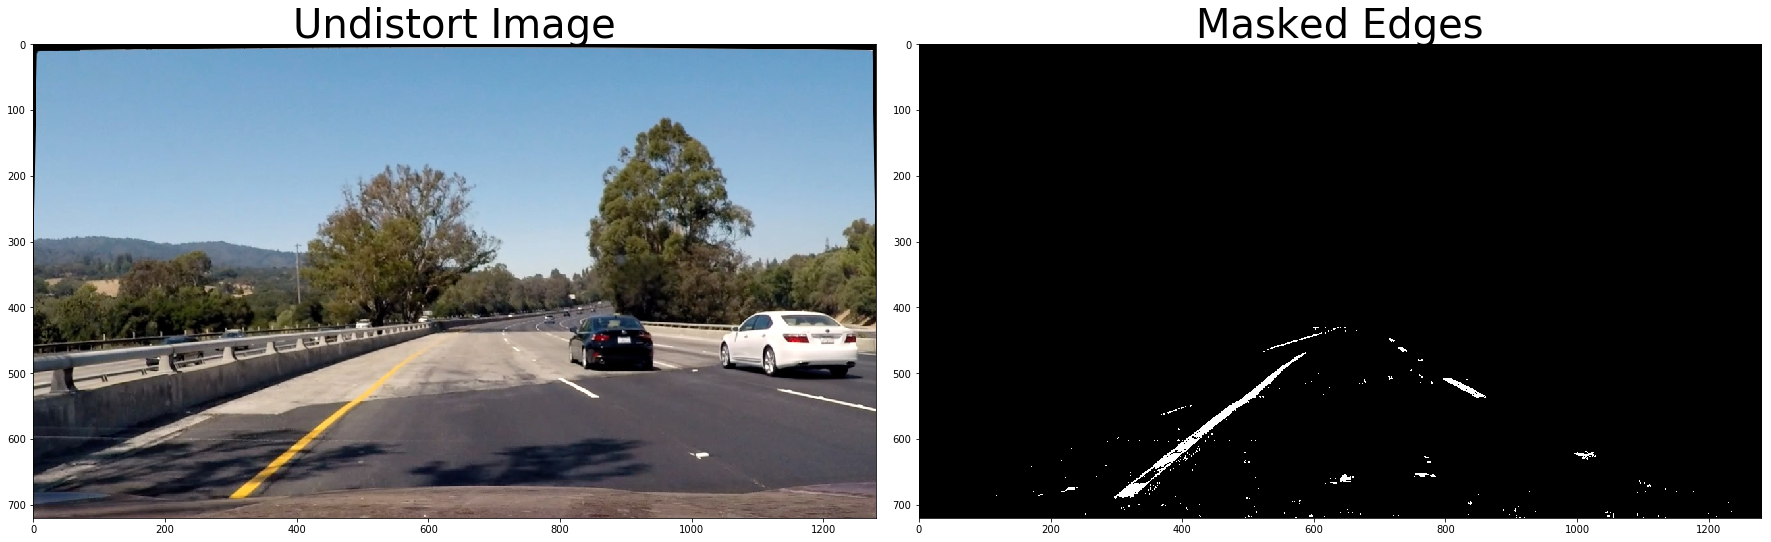

In [10]:
# 9th Code Cell
def detect_line(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    '''
    Use color transforms, gradients, etc., to create a thresholded binary image
    '''
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    vertices = define_vertices(combined_binary)
    masked_edges = region_of_interest(combined_binary, vertices)
    
    return masked_edges
    
masked_test_edges = detect_line(undistort_test_image)

filename_new = 'output_images'+'/'+ 'masked_edges'+file_extension
mpimg.imsave(filename_new, masked_test_edges)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistort_test_image)
ax1.set_title('Undistort Image', fontsize=40)

ax2.imshow(masked_test_edges, cmap='gray')
ax2.set_title('Masked Edges', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

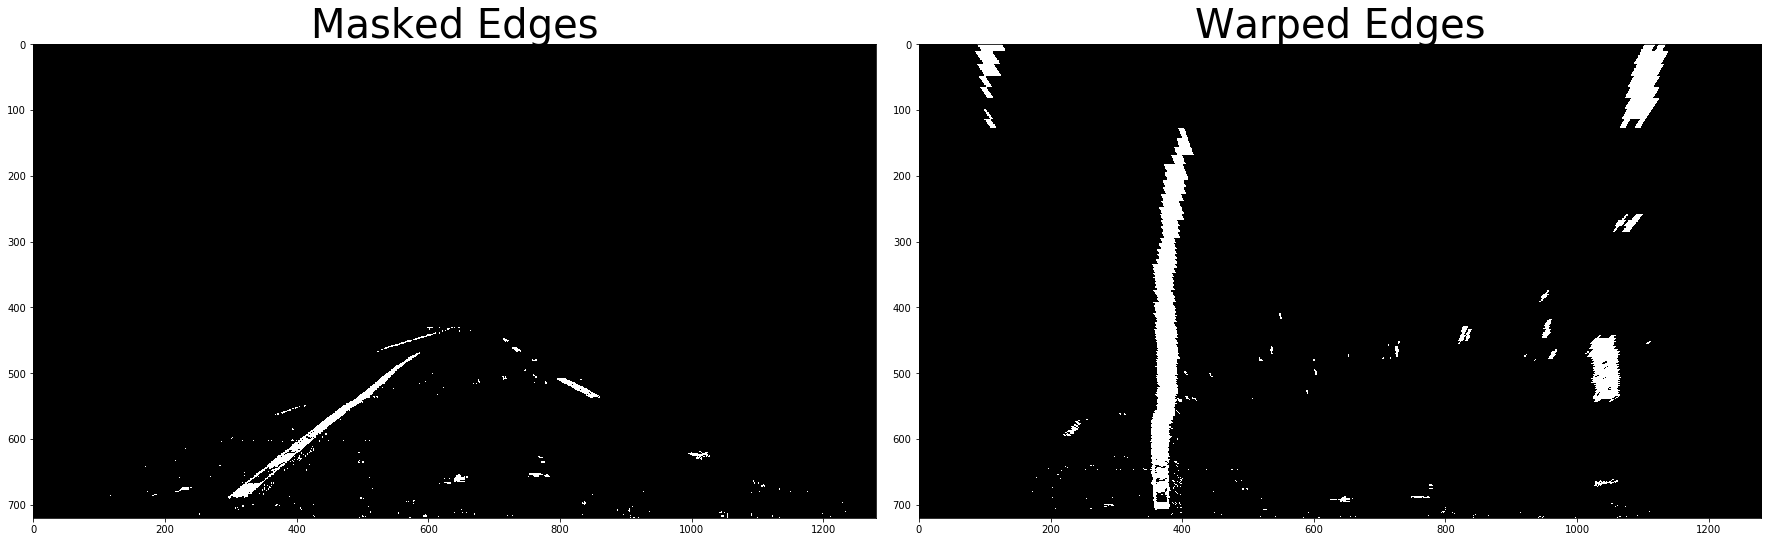

In [11]:
# 10th Code Cell
img_size = (test_image.shape[1], test_image.shape[0])

src = np.float32(
[[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 10, img_size[1]],
[(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])


def warper(img, src, dst):
    '''
    Apply a perspective transform to rectify binary image ("birds-eye view")
    '''
    # Compute and apply perpective transform 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image 
    return warped, M, Minv

binary_warped_test, M_test, Minv_test = warper(masked_test_edges, src, dst)
filename_new = 'output_images'+'/'+ 'binary_warped'+file_extension
mpimg.imsave(filename_new, binary_warped_test)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(masked_test_edges, cmap='gray')
ax1.set_title('Masked Edges', fontsize=40)

ax2.imshow(binary_warped_test, cmap='gray')
ax2.set_title('Warped Edges', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

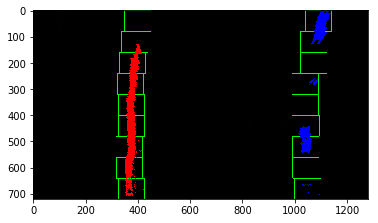

In [12]:
# 11th Code Cell
def find_lane_pixels(binary_warped):
    '''
    Detect lane pixels
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//6:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    '''
    Fit a Polynomial
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, left_fit_cr, right_fit_cr


lane_detected_test, left_fit_test, right_fit_test, left_fitx_test, right_fitx_test, left_fit_cr_test, right_fit_cr_test= fit_polynomial(binary_warped_test)
plt.imshow(lane_detected_test)

filename_new = 'output_images'+'/'+ 'lane_detection'+file_extension
mpimg.imsave(filename_new, lane_detected_test)


In [13]:
#12th Code Cell
def measure_middle( left_fit, right_fit):
    '''
    Calculates the location of center of the lane
    '''
    # Calculate x at bottom of picture
    left_bottom =  left_fit[0]*719**2 + left_fit[1]*719 + left_fit[2]
    right_bottom =  right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2]
    lane_center = (left_bottom + right_bottom)/2
    #print(lane_center)
    return lane_center


In [14]:
#13th Code Cell
def measure_curvature(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meter.
    '''
    out_img, left_fit, right_fit,left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped.shape[0]*ym_per_pix
    
    # Implement the calculation of R_curve (radius of curvature) 
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5/np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad_test, right_curverad_test = measure_curvature(binary_warped_test)

print(left_curverad_test, right_curverad_test)


2730.22952723 1472.4940422


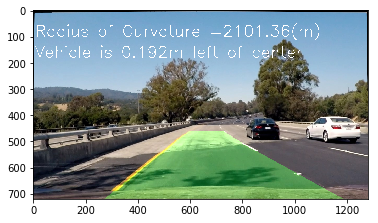

In [15]:
# 14th Code Cell

# Calculat the curvature value and distance from center of road
# These values will  be displaced on top of the picture
def determine_text(masked_edges, undistort,binary_warped, left_fit, right_fit):
    # Calculate the center of the road
    center = measure_middle(left_fit, right_fit)
    # Calculate the vehicle location
    vehicle_location = undistort.shape[1]/2
    # Calculate the distance from center of road
    difference = (vehicle_location - center) * xm_per_pix
    # Determine if vehicle is right or left to center of road
    if difference < 0:
        left_or_right = 'left'
    else:
        left_or_right= 'right'
    difference = np.absolute(difference)
    difference = round(difference, 3)
    # Calculate left lane and right lane curvature
    left_curverad, right_curverad = measure_curvature(binary_warped)
    # Take the average of left and right lane curvature
    ave_curverad = round((left_curverad+right_curverad)/2, 2)
    return difference, left_or_right, ave_curverad

#  Project measurement back down onto the road
def draw_area(binary_warped, undistort, Minv, left_fitx, right_fitx, masked_edges,difference, left_or_right, curverad):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistort.shape[1], undistort.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0) 
    
    # Write text onto picture

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (8,100)
    bottomLeftCornerOfText2 = (8,180)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 2
    

    cv2.putText(result,'Radius of Curvature =' + str(curverad)+'(m)', 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(result,'Vehicle is ' + str(difference) + 'm ' + left_or_right + ' of center', 
        bottomLeftCornerOfText2, 
        font, 
        fontScale,
        fontColor,
        lineType)

    return result

difference_test, left_or_right_test, curverad_test = determine_text(masked_test_edges, undistort_test_image, binary_warped_test, left_fit_test, right_fit_test)
final_test_image = draw_area(binary_warped_test, undistort_test_image, Minv_test, left_fitx_test, right_fitx_test, masked_test_edges, difference_test, left_or_right_test, curverad_test)
plt.imshow(final_test_image)
filename_new = 'output_images'+'/'+ 'final_picture'+file_extension
mpimg.imsave(filename_new, final_test_image)

In [16]:
# Create output folder for test images as instructed below
path_test_image = "test_images_output/"
os.mkdir(path_test_image)

FileExistsError: [Errno 17] File exists: 'test_images_output/'

In [17]:
# Calibrate camera with all chessboard pictures
mtx, dist = camera_calibation_all()

# Make pipeline for test_images
for test_image in os.listdir("test_images/"):
    path = os.path.realpath(test_image)
    filename_w_ext = os.path.basename(path)
    filename, file_extension = os.path.splitext(filename_w_ext)
    # Read in a picture
    image = mpimg.imread("test_images/"+filename_w_ext)
    # Undistort picture
    undistort = undistort_image(image, mtx, dist)
    # Pick the area of interest
    vertices = define_vertices(undistort)
    # Mask the picture
    masked_edges = detect_line(undistort)
    # Warp the picutre
    binary_warped, M, Minv = warper(masked_edges, src, dst)
    # detect lane
    lane_detected, left_fit, right_fit, left_fitx, right_fitx, left_fit_cr, right_fit_cr= fit_polynomial(binary_warped)
    # Calculate curvature and distance from center of lane
    difference, left_or_right, curverad = determine_text(masked_edges, undistort, binary_warped, left_fit, right_fit)
    difference = round(difference, 2)
    # Output final picture
    final_picture = draw_area(binary_warped, undistort, Minv ,left_fitx, right_fitx, masked_edges, difference, left_or_right, curverad)
    # Save final picture
    filename_new = 'test_images_output'+'/'+filename + '_output'+file_extension
    mpimg.imsave(filename_new, final_picture)

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = []    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [20]:
n=20 # Keep track for last 20 pictures
index = 0 # Index for indentify if it's the first time find lane or not. 
                 # First frame, use function: find_lane_pixels
                 # Followin frames, use function: search_around_poly

left_lane = Line() # Line class for left lane
right_lane = Line() # Line class for right lane

left_recent_xfitted  = [] # List to track last n pictures' x values for left lane
left_bestx = [] # List to track last n pictures' averaged best v values for left lane
left_best_fit = [] # List to track last n pictures' average best poly for left lane
left_curvature_list = [] #List to track last n pictures' average curvature for left lane

right_recent_xfitted  = []
right_bestx = []
right_best_fit = []
right_curvature_list = []

difference_list = [] #List to track last n pictures' distance from center of lane

In [21]:
# Make pipeline for video
def process_video(image):
    global index
    #print(index)
    # Undistort raw picture
    undistort = undistort_image(image, mtx, dist)
    # Mask picture to only interested area
    masked_edges = detect_line(undistort)
    # Warp picture
    binary_warped, M, Minv = warper(masked_edges, src, dst)
    # Calculate left lane curvature and right curvature for current picture
    left_curverad, right_curverad = measure_curvature(binary_warped)
    #Detect lane pixels and fit to find the lane boundary.
    lane_detected, left_fit, right_fit, left_fitx, right_fitx, left_fit_cr, right_fit_cr= fit_polynomial(binary_warped)
    
    #index += 1 # Update index
    #print(index)
    #distance in meters of vehicle center from the line
    difference, left_or_right, curverad = determine_text(masked_edges, undistort, binary_warped, left_fit, right_fit)
    
    
    # Update left_lane  class
    # was the line detected in the last iteration?
    if left_fit.any() != 0:
        left_lane.detected= True
        
    # x values of the last n fits of the line
    if(len(left_recent_xfitted) <  n):
        left_recent_xfitted.append(left_fitx)
    else:
        del left_recent_xfitted[0]
        left_recent_xfitted.append(left_fitx)
    left_lane.recent_xfitted = left_recent_xfitted
        
    #average x values of the fitted line over the last n iterations
    left_recent_xfitted_sum = np.sum(left_recent_xfitted, axis=0)
    left_recent_xfitted_ave = np.divide(left_recent_xfitted_sum, len(left_recent_xfitted))
    left_lane.bestx = left_recent_xfitted_ave
    
    #polynomial coefficients averaged over the last n iterations
    if(len(left_best_fit) < n):
        left_best_fit.append(left_fit)
    else:
        del  left_best_fit[0]
        left_best_fit.append(left_fit)
    left_best_fit_sum = np.sum(left_best_fit, axis=0)
    left_best_fit_ave = np.divide(left_best_fit_sum, len(left_best_fit))
    left_lane.best_fit = left_best_fit_ave
    
    #polynomial coefficients for the most recent fit
    left_lane.current_fit = left_fit
    
    #difference in fit coefficients between last and new fits
    left_lane.diffs = left_fit - left_best_fit_ave
    
    #radius of curvature of the line in some units
    if(len(left_curvature_list) < n):
        left_curvature_list.append(left_curverad)
    else:
        del  left_curvature_list[0]
        left_curvature_list.append(left_curverad)
    left_lane.radius_of_curvature =sum(left_curvature_list)/len(left_curvature_list)
    
    # Calculate the average distance from center of lane for the last n pictures
    if(len(difference_list) < n):
        difference_list.append(difference)
    else:
        del  difference_list[0]
        difference_list.append(difference)

    difference_average = sum(difference_list)/len(difference_list)
    difference_average = round(difference_average, 3)
    left_lane.line_base_pos = difference_average
    
    
    
    # Update right_lane  class
    # was the line detected in the last iteration?
    if right_fit.any() != 0:
        right_lane.detected= True
        
    # x values of the last n fits of the line
    if(len(right_recent_xfitted) <  n):
        right_recent_xfitted.append(right_fitx)
    else:
        del right_recent_xfitted[0]
        right_recent_xfitted.append(right_fitx)
    right_lane.recent_xfitted = right_recent_xfitted
        
    #average x values of the fitted line over the last n iterations
    right_recent_xfitted_sum = np.sum(right_recent_xfitted, axis=0)
    right_recent_xfitted_ave = np.divide(right_recent_xfitted_sum, len(right_recent_xfitted))
    right_lane.bestx = right_recent_xfitted_ave
    
    #polynomial coefficients averaged over the last n iterations
    if(len(right_best_fit) < n):
        right_best_fit.append(right_fit)
    else:
        del  right_best_fit[0]
        right_best_fit.append(right_fit)
    right_best_fit_sum = np.sum(right_best_fit, axis=0)
    right_best_fit_ave = np.divide(right_best_fit_sum, len(right_best_fit))
    right_lane.best_fit = right_best_fit_ave
    
    #polynomial coefficients for the most recent fit
    right_lane.current_fit = right_fit
    
    #difference in fit coefficients between last and new fits
    right_lane.diffs = right_fit - right_best_fit_ave
    
    #radius of curvature of the line in some units
    if(len(right_curvature_list) < n):
        right_curvature_list.append(right_curverad)
    else:
        del  right_curvature_list[0]
        right_curvature_list.append(right_curverad)
    right_lane.radius_of_curvature =round(sum(right_curvature_list)/len(right_curvature_list), 2)
    
    #distance in meters of vehicle center from the line
    right_lane.line_base_pos = left_lane.line_base_pos
    
    # Take the aerage between left lane curvatureand right curvature. 
    curverad_average = (left_lane.radius_of_curvature + right_lane.radius_of_curvature) / 2
    curverad_average = round(curverad_average, 2)
    #difference = round(difference, 3)
    
    # Output final picture
    final_picture = draw_area(binary_warped, undistort, Minv, left_lane.bestx, right_lane.bestx, masked_edges, difference, left_or_right, curverad_average)


    return final_picture

In [22]:
video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:51<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 30s, sys: 18 s, total: 3min 48s
Wall time: 5min 54s
